In [73]:
import requests
import time
from tempfile import TemporaryDirectory
from IPython.display import clear_output, FileLink, Image, display
from zipfile import ZipFile
from pyarrow import parquet
import json
import os

COSMOS_BASE_URL = "http://cosmos0004.chtc.wisc.edu:8089/cosmos_service"
SAMPLE_PDF_URL = "https://www.nature.com/articles/s41591-020-0883-7.pdf"
SAMPLE_PDF_PATH = "sidarthe.pdf"


### Submit a PDF for Processing

Make a POST request to the base URL containing a multipart form with the contents of the file in the `pdf` field.
Other form fields include:
- `compress_images` (default `True`): Return compressed JPG images if `True`, uncompressed PNGs otherwise.  

In [70]:
# Download a local copy of the PDF

with open(SAMPLE_PDF_PATH, 'wb') as pdf_writer:
    pdf_writer.write(requests.get(SAMPLE_PDF_URL).content)


In [78]:
# Submit the locally copied PDF to the COSMOS processing pipeline

submit_endpoint = COSMOS_BASE_URL + '/process/'

with open(SAMPLE_PDF_PATH, 'rb') as pdf_to_parse:
    file_form = {'pdf': pdf_to_parse }
    data_form = {'compress_images': False }

    response = requests.post(submit_endpoint, files=file_form, data=data_form)

    response_data = response.json()
    job_id = response_data['job_id']

    status_endpoint = response_data['status_endpoint']
    results_endpoint = response_data['result_endpoint']

    print(f"Message: {response_data['message']}\n"
          f"Job ID: {response_data['job_id']}\n"
          f"Status Endpoint: {status_endpoint}\n"
          f"Results Endpoint: {results_endpoint}")


Message: Existing PDF Processing Job Found
Job ID: ce4df4a5-3e9d-433d-bb2a-19717d64a2a5
Status Endpoint: http://cosmos0004.chtc.wisc.edu:8088/cosmos_service/process/ce4df4a5-3e9d-433d-bb2a-19717d64a2a5/status
Results Endpoint: http://cosmos0004.chtc.wisc.edu:8088/cosmos_service/process/ce4df4a5-3e9d-433d-bb2a-19717d64a2a5/result


### Monitor COSMOS Processing Status

Poll the URL suffix returned in the `status_endpoint` field of the initial response object.
For the sample document, processing can take up to 5 minutes. The `/status` endpoint
will return several fields, including a `job_completed` field and an `error` field which initially 
`false` and `null` respectively. If the `job_completed` field becomes `true`, then the job completed 
successfully, and if the `error` field becomes non-`null` then the job failed. 

In [79]:
POLL_COUNT = 80
POLL_INTERVAL = 5

job_done = False

for i in range(POLL_COUNT):
    response = requests.get(status_endpoint)
    response_data = response.json()
    clear_output(wait=True)
    print(f"Polled status endpoint {i} times:\n{response_data}")
    job_done = response_data['error'] or response_data['job_completed']
    if job_done:
        break
    time.sleep(POLL_INTERVAL)

if not job_done:
    print(f"ERROR: Job not complete after {POLL_COUNT * POLL_INTERVAL} seconds.")
elif response_data['error']:
    print(f"An unexpected error occurred: {response_data['error']}")
else:
    print(f"Job succeeded after {response_data['time_processing']} seconds.\n"
          f"Results can be viewed at {results_endpoint}")


Polled status endpoint 0 times:
{'job_started': True, 'job_completed': True, 'error': None, 'time_in_queue': 10.349598, 'time_processing': 254.614307}
Job succeeded after 254.614307 seconds.
Results can be viewed at http://cosmos0004.chtc.wisc.edu:8088/cosmos_service/process/ce4df4a5-3e9d-433d-bb2a-19717d64a2a5/result


### Obtain Results

Once the `/status` endpoint indicates that `job_completed` is `true`, the following endpoints will be available via GET request:
- `/result/text`: The text extracted from the document, alongside its bounding boxes and classification, as JSON.
- `/result/extractions/{extraction_type}`: The bounding boxes of individual extraction types, and temporary links to their images, as JSON. 
  Valid extraction types are `equations`, `figures`, and `tables`.
- `/result/images/{image_id}`: Temporary image hosting for the cosmos extractions.
- `/result`: The entire contents of the cosmos processing job as a zip file, containing images of extracted pdf regions and parquet files with those extractions' metadata.

All results are available for 24 hours after image processing completes, after which they will be deleted.

### Extractions (JSON)

In [ ]:
# Extracted document text and bounding boxes
text_data = requests.get(f"{results_endpoint}/text")
print(text_data)
# print(json.dumps(text_data.json(), indent=2))


In [25]:
# Extracted document equations, bounding boxes, and images
equation_data = requests.get(f"{results_endpoint}/extractions/equations")
print(f"{results_endpoint}/extractions/equations")
print(json.dumps(equation_data.json(), indent=2))

http://cosmos0003.chtc.wisc.edu:8089/cosmos_service/process/abe638a0-34b5-4df1-b0c7-889a81f0c683/result/extractions/equations
[
  {
    "pdf_name": "sidarthe.pdf",
    "page_num": 1,
    "bounding_box": [
      155,
      857,
      461,
      892
    ],
    "detect_score": -0.2537487745,
    "content": null,
    "postprocess_score": 0.5157092214,
    "img_pth": "http://cosmos0003.chtc.wisc.edu:8089/cosmos_service/process/abe638a0-34b5-4df1-b0c7-889a81f0c683/result/images/e7b30cdc-48f4-4f78-ad5a-69b8d1e25ba4.png"
  },
  {
    "pdf_name": "sidarthe.pdf",
    "page_num": 1,
    "bounding_box": [
      156,
      1272,
      461,
      1305
    ],
    "detect_score": -4.5794801712,
    "content": "CO2",
    "postprocess_score": 0.990517199,
    "img_pth": "http://cosmos0003.chtc.wisc.edu:8089/cosmos_service/process/abe638a0-34b5-4df1-b0c7-889a81f0c683/result/images/1be134d0-d09a-45fb-8c95-cf57d32f9ddd.png"
  },
  {
    "pdf_name": "sidarthe.pdf",
    "page_num": 1,
    "bounding_box": [
 

In [ ]:
# Extracted document figures, bounding boxes, and images
figure_data = requests.get(f"{results_endpoint}/extractions/figures")
print(json.dumps(figure_data.json(), indent=2))


In [ ]:
# Extracted document tables, bounding boxes, and images
table_data = requests.get(f"{results_endpoint}/extractions/tables")
print(json.dumps(table_data.json(), indent=2))


### Full Results (Zip)

In [76]:
ZIP_DOWNLOAD_PATH = SAMPLE_PDF_PATH.replace('.pdf', '.zip')
with open(ZIP_DOWNLOAD_PATH, 'wb') as writer:
    writer.write(requests.get(results_endpoint).content)

print(f'You can access the downloaded zip file at {FileLink(ZIP_DOWNLOAD_PATH)} .\nIt contains the following files:')

with ZipFile(ZIP_DOWNLOAD_PATH, 'r') as zipfile:
    zipfile.printdir()


You can access the downloaded zip file at /home/westphall/xdd/Cosmos/notebooks/cosmos-service/sidarthe.zip .
It contains the following files:
File Name                                             Modified             Size
sidarthe_figures.parquet                       2024-02-27 16:07:30        17395
b218aac0-965c-41a9-ad7b-33f67ecbde9a.png       2024-02-27 16:07:30         6231
2758fffe-67c7-4eec-a0bd-af482fe11985.png       2024-02-27 16:07:24        66658
5c6ed0b8-002e-49bb-8e34-52a02704b2ac.png       2024-02-27 16:07:42         8004
99090d14-83e9-4cf3-a148-7c9c4c865942.png       2024-02-27 16:07:26         7499
94f81789-5aad-4df1-a380-59654eb5381d.png       2024-02-27 16:07:42         7505
e68e2997-6f2e-4e8d-a1e0-7ecc7ed7cf64.png       2024-02-27 16:07:42         7575
46cb1d70-2094-4da6-9531-d88625d8844b.png       2024-02-27 16:07:28        30774
9f9b373e-04e3-43f4-bd9c-0ea7b31bdc95.png       2024-02-27 16:07:28        37223
3f42445d-b338-440a-b00e-9b62c8d29b58.png       2024-02-27 

### View Figures

The zip file contains a number of image files, as well as apache parquet files containing information about those images.
Each parquet file contains information about a separate extraction type (tables, figures, and equations). The names of each
parquet file are based on the name of the input PDF file.

In [63]:
def show_extractions(parquet_path, bb_column, page_column):
    """Utility function to show every extraction from a single COSMOS Parquet file"""
    with (TemporaryDirectory() as td, ZipFile(ZIP_DOWNLOAD_PATH, 'r') as zipfile):
        # extract the parquet file from the zip archive
        zipfile.extract(parquet_path, td)
        # read the parquet file
        parquet_table = parquet.read_table(os.path.join(td, parquet_path))
        pandas_data: pd.DataFrame = parquet_table.to_pandas()
        # TODO the img_path column currently contains the absolute path of the image on the server,
        # rather than the relative path from the root of the zip folder
        pandas_data['img_pth'] = pandas_data['img_pth'].replace('/tmp/tmp.*/','',regex=True)

        # Print each extraction alongside its score, page, and bounding box
        for idx, row in pandas_data.iterrows():
            img_path = row['img_pth']
            zipfile.extract(img_path, td)
            print(f"Extracted Item #{idx+1}\n"
                  f"Page: {row[page_column]}\n"
                  f"Bounding Box: {row[bb_column]}\n"
                  f"Content: {row['content']}\n"
                  f"Score: {row['postprocess_score']}")
            display(Image(os.path.join(td,img_path)))


In [ ]:
# Figures
show_extractions(
    'paper.pdf'.replace('.pdf','_figures.parquet'), 
    'obj_bbs',
    'obj_page')


Extracted Item #1
Page: 1
Bounding Box: [1163.44250488  173.03813171 1346.44250488  217.03813171]
Content: None
Score: 0.8684460520744324


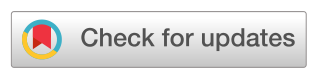

Extracted Item #2
Page: 7
Bounding Box: [233.97346497 230.13433838 574.97346497 261.13433838]
Content: None
Score: 0.9997474551200867


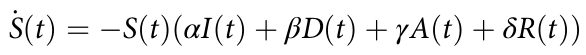

Extracted Item #3
Page: 7
Bounding Box: [352.90478516 637.65240479 455.90478516 668.65240479]
Content: None
Score: 0.9906574487686157


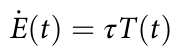

Extracted Item #4
Page: 7
Bounding Box: [ 815.92095947 1640.28564453 1259.92095947 1668.28564453]
Content: None
Score: 0.9995781779289246


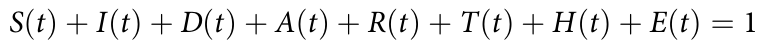

Extracted Item #5
Page: 7
Bounding Box: [ 842.27636719 1770.25219727 1235.27636719 1799.25219727]
Content: None
Score: 0.9997631907463074


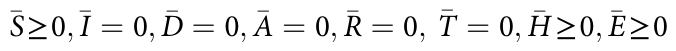

Extracted Item #6
Page: 7
Bounding Box: [227.73002625 580.44018555 580.73002625 611.44018555]
Content: None
Score: 0.9977259039878845


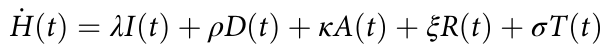

Extracted Item #7
Page: 7
Bounding Box: [174.98272705 289.26315308 633.98272705 319.26315308]
Content: None
Score: 0.7989088296890259


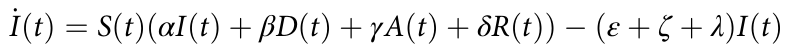

Extracted Item #8
Page: 7
Bounding Box: [ 841.92303467 1769.82763672 1234.92303467 1798.82763672]
Content: None
Score: 0.9989126920700073


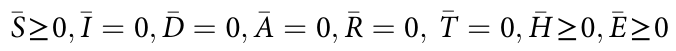

Extracted Item #9
Page: 8
Bounding Box: [131.19802856 543.22802734 665.19802856 681.22802734]
Content: None
Score: 0.9745124578475952


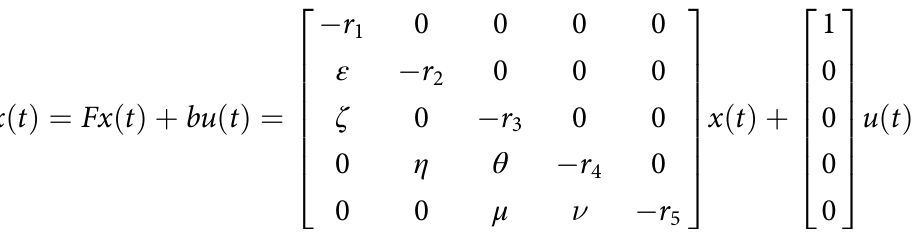

Extracted Item #10
Page: 8
Bounding Box: [342.14382935 883.35296631 467.14382935 911.35296631]
Content: None
Score: 0.9993478655815125


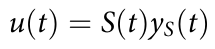

Extracted Item #11
Page: 8
Bounding Box: [ 336.48168945  980.71295166  474.48168945 1011.71295166]
Content: None
Score: 0.9006357789039612


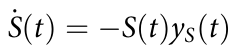

Extracted Item #12
Page: 8
Bounding Box: [ 350.66699219 1038.97814941  456.66699219 1069.97814941]
Content: None
Score: 0.9947852492332458


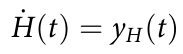

Extracted Item #13
Page: 8
Bounding Box: [ 354.27444458 1096.80932617  454.27444458 1127.80932617]
Content: None
Score: 0.9714825749397278


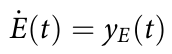

Extracted Item #14
Page: 8
Bounding Box: [ 211.4499054  1261.02539062  599.4499054  1308.02539062]
Content: None
Score: 0.9998514652252197


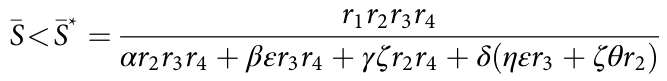

Extracted Item #15
Page: 8
Bounding Box: [ 325.48806763 1657.44262695  485.48806763 1686.44262695]
Content: None
Score: 0.9998596906661987


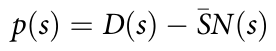

Extracted Item #16
Page: 8
Bounding Box: [ 165.6829834 1732.9654541  639.6829834 1804.9654541]
Content: None
Score: 0.9994768500328064


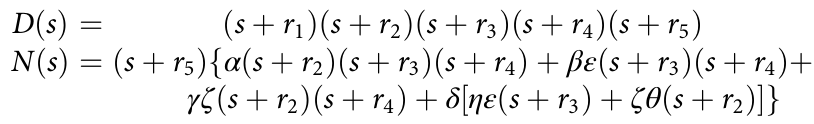

Extracted Item #17
Page: 8
Bounding Box: [ 822.79095459  310.45513916 1254.79095459  359.45513916]
Content: None
Score: 0.9975785613059998


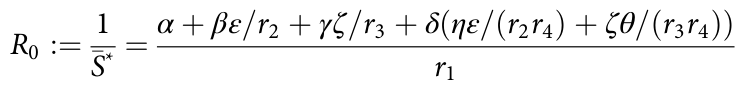

Extracted Item #18
Page: 8
Bounding Box: [ 869.73699951  826.41491699 1206.73699951  854.41491699]
Content: None
Score: 0.9996238946914673


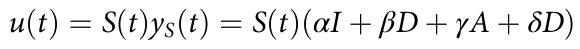

Extracted Item #19
Page: 8
Bounding Box: [ 871.34033203  958.65844727 1206.34033203 1009.65844727]
Content: None
Score: 0.9990726709365845


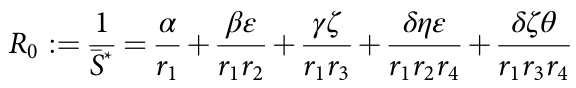

Extracted Item #20
Page: 8
Bounding Box: [1008.02471924 1052.34509277 1068.02471924 1080.34509277]
Content: None
Score: 0.9875456690788269


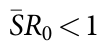

Extracted Item #21
Page: 8
Bounding Box: [ 884.14111328 1582.54748535 1191.14111328 1645.54748535]
Content: None
Score: 0.9998003840446472


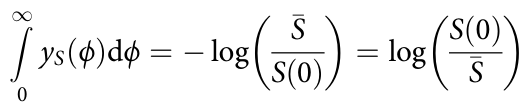

Extracted Item #22
Page: 8
Bounding Box: [ 909.17999268 1744.19262695 1163.17999268 1807.19262695]
Content: None
Score: 0.9991891980171204


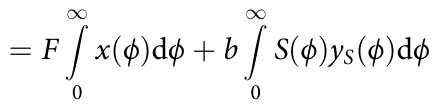

Extracted Item #23
Page: 8
Bounding Box: [680.5090332  597.88555908 710.5090332  625.88555908]
Content: None
Score: 0.3975766897201538


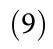

Extracted Item #24
Page: 8
Bounding Box: [ 760.35870361 1654.50695801 1100.35870361 1689.50695801]
Content: None
Score: 0.9967283010482788


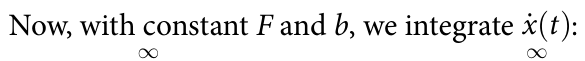

Extracted Item #25
Page: 8
Bounding Box: [ 731.98840332 1018.38238525 1104.98840332 1045.38238525]
Content: None
Score: 0.5414783358573914


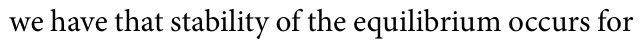

Extracted Item #26
Page: 8
Bounding Box: [ 758.54528809 1088.84777832 1280.54528809 1118.84777832]
Content: None
Score: 0.6371824145317078


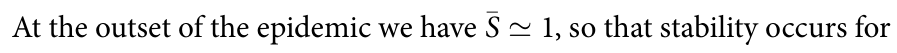

Extracted Item #27
Page: 8
Bounding Box: [ 166.09677124 1733.32080078  636.09677124 1805.32080078]
Content: None
Score: 0.9994994401931763


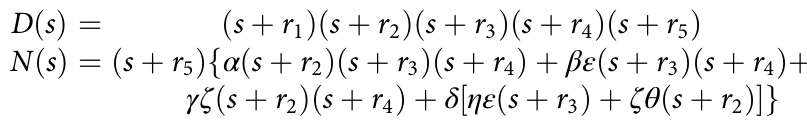

Extracted Item #28
Page: 8
Bounding Box: [ 759.51824951 1655.32287598 1233.51824951 1736.32287598]
Content: None
Score: 0.8718130588531494


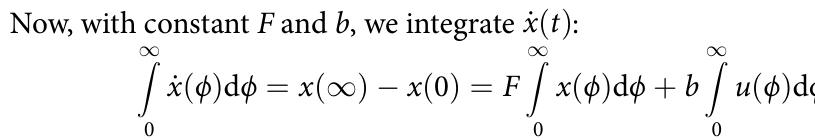

Extracted Item #29
Page: 8
Bounding Box: [ 350.78747559 1038.93774414  456.78747559 1069.93774414]
Content: None
Score: 0.9979680180549622


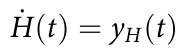

Extracted Item #30
Page: 8
Bounding Box: [664.30981445 883.02667236 710.30981445 953.02667236]
Content: None
Score: 0.6737967729568481


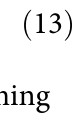

Extracted Item #31
Page: 8
Bounding Box: [673.30981445 767.02667236 710.30981445 795.02667236]
Content: None
Score: 0.6737967729568481


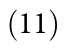

Extracted Item #32
Page: 8
Bounding Box: [ 673.30981445 1099.02667236  711.30981445 1128.02667236]
Content: None
Score: 0.6737967729568481


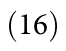

Extracted Item #33
Page: 8
Bounding Box: [ 673.30981445 1041.02667236  710.30981445 1070.02667236]
Content: None
Score: 0.6737967729568481


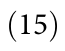

Extracted Item #34
Page: 8
Bounding Box: [673.30981445 709.02667236 710.30981445 737.02667236]
Content: 17
Score: 0.6737967729568481


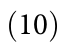

Extracted Item #35
Page: 8
Bounding Box: [ 673.30981445  983.02667236  710.30981445 1011.02667236]
Content: None
Score: 0.6737967729568481


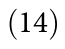

Extracted Item #36
Page: 8
Bounding Box: [673.30981445 825.02667236 710.30981445 853.02667236]
Content: None
Score: 0.6737967729568481


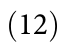

Extracted Item #37
Page: 9
Bounding Box: [166.32411194 163.72654724 644.32411194 226.72654724]
Content: None
Score: 0.9997842907905579


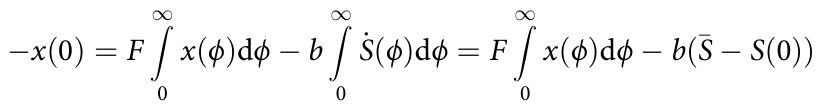

Extracted Item #38
Page: 9
Bounding Box: [102.88095093 277.21194458 706.88095093 340.21194458]
Content: None
Score: 0.8439393043518066


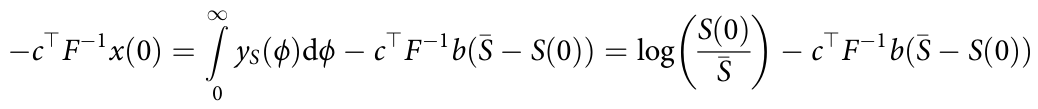

Extracted Item #39
Page: 9
Bounding Box: [282.4593811  409.42199707 522.4593811  463.42199707]
Content: None
Score: 0.9997020363807678


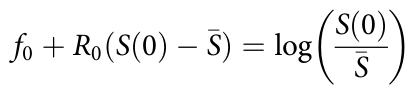

Extracted Item #40
Page: 9
Bounding Box: [355.04492188 596.12432861 451.04492188 624.12432861]
Content: None
Score: 0.9037430286407471


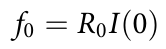

Extracted Item #41
Page: 9
Bounding Box: [208.84141541 883.77697754 600.84141541 937.77697754]
Content: None
Score: 0.9020700454711914


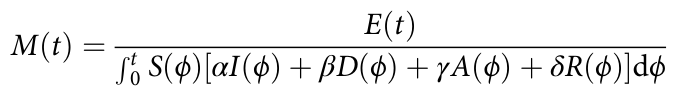

Extracted Item #42
Page: 9
Bounding Box: [ 275.74420166  963.19946289  536.74420166 1017.19946289]
Content: None
Score: 0.9999845027923584


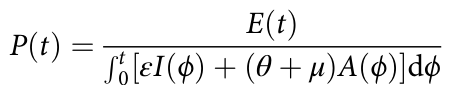

Extracted Item #43
Page: 9
Bounding Box: [ 254.78544617 1066.30944824  555.78544617 1130.30944824]
Content: None
Score: 0.9999572038650513


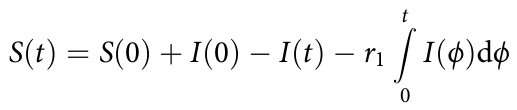

Extracted Item #44
Page: 9
Bounding Box: [ 328.60198975 1178.67260742  480.60198975 1231.67260742]
Content: None
Score: 0.9999363422393799


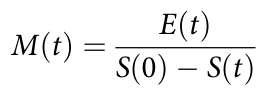

Extracted Item #45
Page: 9
Bounding Box: [ 171.11212158 1261.96911621  642.11212158 1317.96911621]
Content: None
Score: 0.7598218321800232


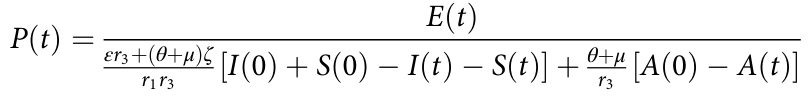

Extracted Item #46
Page: 9
Bounding Box: [ 673.49267578 1083.93017578  711.49267578 1111.93017578]
Content: None
Score: 0.5089432001113892


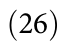

Extracted Item #47
Page: 9
Bounding Box: [ 672.81176758 1192.43518066  710.81176758 1220.43518066]
Content: None
Score: 0.697140097618103


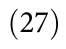

Extracted Item #48
Page: 9
Bounding Box: [ 126.47532654 1029.59790039  313.47532654 1057.59790039]
Content: None
Score: 0.7711684107780457


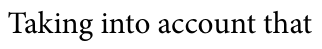

Extracted Item #49
Page: 9
Bounding Box: [125.62998962 125.28574371 472.62998962 156.28574371]
Content: None
Score: 0.7109944820404053


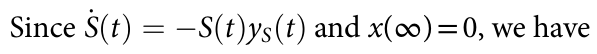

Extracted Item #50
Page: 11
Bounding Box: [ 732.47711182 1087.91259766  949.47711182 1118.91259766]
Content: None
Score: 0.9738154411315918


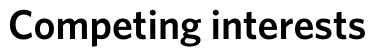

Extracted Item #51
Page: 31
Bounding Box: [ 745.15332031  128.59379578 1114.15332031  157.59379578]
Content: None
Score: 0.9031317234039307


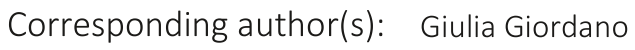

Extracted Item #52
Page: 31
Bounding Box: [ 744.93493652  171.22207642 1082.93493652  200.22207642]
Content: None
Score: 0.9512676000595093


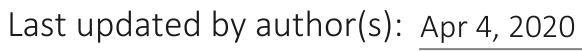

Extracted Item #53
Page: 31
Bounding Box: [  75.19547272 1178.95947266  213.19547272 1203.95947266]
Content: None
Score: 0.9972283244132996


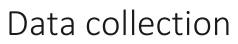

Extracted Item #54
Page: 31
Bounding Box: [  57.29238892 1089.62683105  320.29238892 1122.62683105]
Content: None
Score: 0.7678940892219543


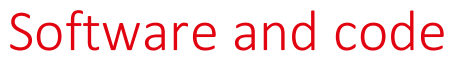

Extracted Item #55
Page: 31
Bounding Box: [  58.04512024 1139.92456055  527.04512024 1168.92456055]
Content: None
Score: 0.7629611492156982


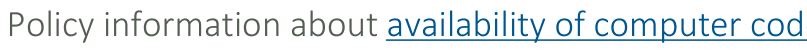

Extracted Item #56
Page: 32
Bounding Box: [ 50.72369385  80.93821716 528.72369385 136.93821716]
Content: None
Score: 0.4955248236656189


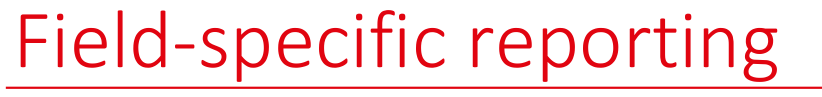

Extracted Item #57
Page: 32
Bounding Box: [ 60.47531128 296.95327759 657.47531128 352.95327759]
Content: None
Score: 0.9986528158187866


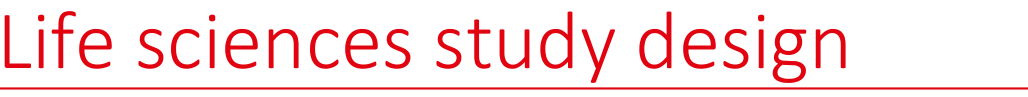

In [77]:
# Equations
show_extractions(
    SAMPLE_PDF_PATH.replace('.pdf','_equations.parquet'), 
    'equation_bb',
    'equation_page')


In [ ]:
# Tables
show_extractions(
    SAMPLE_PDF_PATH.replace('.pdf','_tables.parquet'), 
    'obj_bbs',
    'obj_page')


# Validate Results

COSMOS provides the /healthcheck/evaluate endpoint to evaluate the output of a COSMOS job against an expected set of region bounding boxes. Expected bounding boxes can be generated
by the [COSMOS tagger tool](https://github.com/uw-cosmos/cosmos-visualizer), but should be converted from XML to JSON for use with the health check endpoint. The health check endpoint
returns the [mean average precision score](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Mean_average_precision) for each of the 3 relevant region
identification classes (figures, tables, and equations) according to the following procedure:

* For each threshold between 50% and 95%, in 5% intervals:
* Label each Cosmos extraction as a true positive if its intersection-over-union with a ground truth region is greater than the threshold
* Compute the [average precision](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Average_precision) of the set of extractions at the given threshold
  * Average Precision is a measure of the change in precision and recall of the model as results with lower confidence scores are considered
* Average the average precision score from each i-o-u threshold

In [73]:
evaluate_endpoint = COSMOS_BASE_URL + f'/healthcheck/evaluate/{job_id}'
with open(SAMPLE_PDF_PATH + '.json', 'rb') as expected_regions:

    response = requests.post(evaluate_endpoint, json=json.loads(expected_regions.read()))

    print(json.dumps(response.json(),indent=2))


[
  {
    "label_class": "Figure",
    "page_comparisons": [
      {
        "page": 2,
        "expected_count": 1,
        "cosmos_count": 1,
        "expected_area": 523569,
        "cosmos_area": 520344,
        "average_precision": 1.0,
        "ap50": 1.0,
        "ap75": 1.0,
        "count_in_bounds": true
      },
      {
        "page": 3,
        "expected_count": 4,
        "cosmos_count": 4,
        "expected_area": 822219,
        "cosmos_area": 805650,
        "average_precision": 1.0,
        "ap50": 1.0,
        "ap75": 1.0,
        "count_in_bounds": true
      },
      {
        "page": 4,
        "expected_count": 4,
        "cosmos_count": 4,
        "expected_area": 858235,
        "cosmos_area": 817035,
        "average_precision": 0.975,
        "ap50": 1.0,
        "ap75": 1.0,
        "count_in_bounds": true
      },
      {
        "page": 5,
        "expected_count": 4,
        "cosmos_count": 4,
        "expected_area": 821191,
        "cosmos_area": 809992